In [1]:
import pandas as pd
import geopandas as gpd
# import pycountry
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import plotly.graph_objects as go
from shapely.geometry import Polygon,  Point
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

C:\Users\User\AppData\Local\Temp/ipykernel_14832/1280172089.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centeroid'] = gdf.centroid
C:\Users\User\AppData\Local\Temp/ipykernel_14832/1280172089.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  clb1.ax.set_yticklabels(['100%','80%','60%','40%','20%','0%'],  fontsize=16)
C:\Users\User\AppData\Local\Temp/ipykernel_14832/1280172089.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  clb2.ax.set_yticklabels([


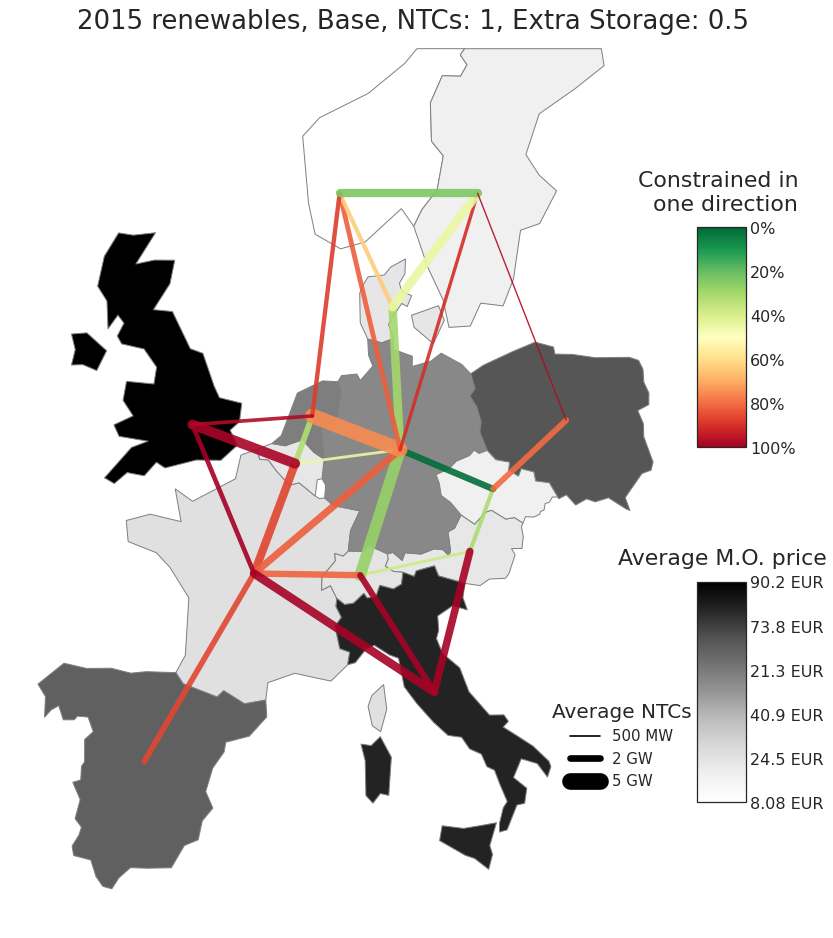

In [72]:
# Debugging....
Time_steps = 1
save_type = 'png'
scen = ["false", "Base", 1.0, 0.5, Time_steps]
ntc_fac = scen[2]
sto_fac = scen[3] 
ntc_fac = 1
year = 2015


name_prices = f"false_Base_1.0_0.5_res_mc_grouped_by_zone_year_max.csv"
name_ntcs = f"false_Base_1.0_0.5_line_constrain_map.csv"
name_plot = f"{scen[0]}_{scen[1]}_{ntc_fac}_{sto_fac}_Map.{save_type}"
name_title = f'{year} renewables, {scen[1]}, NTCs: {ntc_fac}, Extra Storage: {sto_fac}'
ntc_df, gdf = fetch_map_info(name_ntcs,name_prices, ntc_fac)
plot = plot_map(ntc_df, gdf, name_title)
# plot_path = path+ name_plot
# ntc_df[ntc_df.toZ=="Switzerland"]

This is where the real plotting starts


In [71]:
#  Functions
def fetch_map_info(name_ntcs, name_prices, ntc_factor):
    country_dict = pd.read_csv('data/Map/country_codes.csv').set_index('Code').to_dict()
    ntc_max = pd.read_csv('data/Map/ntc_max.csv')
    ntc_max["ntc_max"] = ntc_max["ntc_max"] * ntc_factor

    ntc_df = pd.read_csv(f'data/Map/{name_ntcs}')
    ntc_df = ntc_df.rename(columns={'from':'fromZ','to':'toZ'})
    ntc_df['fromZ'] = [country_dict['Name'][x] for x in ntc_df['fromZ']]
    ntc_df['toZ'] = [country_dict['Name'][x] for x in ntc_df['toZ']]

    ntc_df['mergeOn'] = [tuple(set([ntc_df.loc[x,"fromZ"], ntc_df.loc[x,"toZ"]])) for x in ntc_df.index]
    ntc_max['mergeOn'] = [tuple(set([ntc_max.loc[x,"fromZ"], ntc_max.loc[x,"toZ"]])) for x in ntc_df.index]
    ntc_max.drop(['fromZ','toZ'], axis=1, inplace=True)
    ntc_df = pd.merge(ntc_max, ntc_df, on='mergeOn')
    ntc_df.drop('mergeOn', axis=1, inplace=True)

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


    price_data = pd.read_csv(f'data/Map/{name_prices}').drop('mc_el_maximum_std', axis=1)
    countries = price_data.zone.unique()
    countries = [country_dict['Name'][x] for x in countries]
    price_data = price_data.set_index('zone')
    price_dict = price_data.T.to_dict('index')
    price_dict = {country_dict['Name'][key]: value for key, value in price_dict['mc_el_maximum_mean'].items()}
    gdf = world.loc[world['name'].isin(countries),:].copy()
    gdf['value'] = gdf['name'].map(price_dict)

    gdf['centeroid'] = gdf.centroid
    # correcting centeroids that seem off
    gdf.loc[gdf['name'] == 'France', 'centeroid'] = Point(2.35, 46.85)
    gdf.loc[gdf['name'] == 'Norway', 'centeroid'] = Point(7.00, 60.00)
    gdf.loc[gdf['name'] == 'Sweden', 'centeroid'] = Point(14.50, 60.00)
    gdf.loc[gdf['name'] == 'United Kingdom', 'centeroid'] = Point(-1, 52.00)

    ntc_df['from_coordinates'] = [gdf.loc[gdf['name']== x, 'centeroid'] for x in ntc_df['fromZ']]
    ntc_df['to_coordinates'] = [gdf.loc[gdf['name']== x, 'centeroid'] for x in ntc_df['toZ']]
    
    return ntc_df, gdf

    # plotting
def plot_map(ntc_df, gdf, name_title):
    scale_factor = 300 # thickness of the inteconnector lines
    # scaling map to only central europe (french guinea and islands are removed)
    polygon = Polygon([(-25,35), (40,35), (40,65),(-25,65)])
    gdf = gpd.clip(gdf, polygon)
    with plt.style.context(("seaborn-white")):
        # Plot countries with the yearly average highest marginal prices
        gdf.plot('value', figsize=(17,17), edgecolor="grey")

        ## Loop throughthe NTC data and add the interconnections
        for n in ntc_df.index:
            plt.plot([ntc_df.loc[n,'from_coordinates'].x , ntc_df.loc[n,'to_coordinates'].x] 
                    , [ntc_df.loc[n,'from_coordinates'].y, ntc_df.loc[n,'to_coordinates'].y], 
                    linewidth= ntc_df.loc[n,'ntc_max']/scale_factor, color= cm.RdYlGn(1 - ntc_df.loc[n,'constrained_maximum_mean']), alpha=0.9 )
        plt.title(name_title, fontsize=26, y=0.97, x=0.6)

        # removing ugly box from around plot
        plt.box(False)
        plt.tick_params(left = False, right = False , labelleft = False ,
                        labelbottom = False, bottom = False)

        # Colorbar axis for the constrain on the interconnector
        cax1 = plt.axes([0.8, 0.52, 0.04, 0.18])
        clb1 = plt.colorbar(cm.ScalarMappable(norm=None, cmap="RdYlGn"), cax=cax1)
        clb1.ax.set_yticklabels(['100%','80%','60%','40%','20%','0%'],  fontsize=16)
        clb1.ax.set_title('Constrained in \n one direction',fontsize=22, y=1.05)

        # Colorbar axus fir the countries electricity prices
        cax2 = plt.axes([0.8, 0.23, 0.04, 0.18])
        clb2 = plt.colorbar(cm.ScalarMappable(norm=None, cmap=None), cax=cax2)
        clb2.ax.set_yticklabels([
        str(round(min(gdf['value']), 2))+' EUR',
        str(round(max(gdf['value'])*0.2 + min(gdf['value'])*0.8, 1))+' EUR',
        str(round(max(gdf['value'])*0.4 + min(gdf['value'])*0.6, 1))+' EUR',
        str(round(max(gdf['value'])*0.2 + min(gdf['value'])*0.4, 1))+' EUR',
        str(round(max(gdf['value'])*0.8 + min(gdf['value'])*0.2, 1)) +' EUR',
        str(round(max(gdf['value']),1)) +' EUR',
        ], fontsize=16 )
        clb2.ax.set_title('Average M.O. price',fontsize=22, y=1.05)

        # Interconnector capacities legend
        line1, = plt.plot(0, 1, linewidth=(500/scale_factor), color='black')
        line2, = plt.plot(0, 1, linewidth=(2000/scale_factor), color='black')
        line3, = plt.plot(0, 1, linewidth=(5000/scale_factor), color='black')
        plt.legend([line1, line2, line3], 
                    ['500 MW', '2 GW', '5 GW'],
                    loc='lower right', bbox_to_anchor=(0.01, 0, 0.15, 0.1),
                    prop={'size': 15}, title="Average NTCs", title_fontsize=20
                    )
        return plt

In [ ]:
path = r"C:\Users\User\Documents\GitHub\EWMOD\Term-Paper\Map_results/"
save_type = "png"
Time_steps = 8760
scenario_list = [[False, "Base", 1, 0, Time_steps], #1
                [True, "Base", 1, 0, Time_steps], #2
                [True, "Minus_50", 1 ,0, Time_steps], #3
                [True, "Atomkraft_Nein_Danke", 1, 0, Time_steps], #4
                [True, "Mixed_FR_PL_exept", 1, 0, Time_steps], #5
                ]
    
# itterating scenario results and plotting maps
for ntc_fac in [1.0,0.8,1.2]:
        for sto_fac in [0.0,0.5,1.0,3.0]:
            for scen in scenario_list:
                if scen[0]:
                    year = 2030
                else:
                    year = 2015
                scen[3] = ntc_fac
                scen[4] = sto_fac
                print(scen)
               
                name_prices = f"{scen[0]}_{scen[1]}_{ntc_fac}_{sto_fac}_res_mc_grouped_by_zone_year_max.csv"
                name_ntcs = f"{scen[0]}_{scen[1]}_{ntc_fac}_{sto_fac}_line_constrain_map.csv"
                name_plot = f"{scen[0]}_{scen[1]}_{ntc_fac}_{sto_fac}_Map.{save_type}"
                name_title = f'{year} renewables, {scen[1]}, NTCs: {ntc_fac}, Extra Storage: {sto_fac}'
                ntc_df, gdf = fetch_map_info(name_ntcs,name_prices, ntc_fac)
                plot = plot_map(ntc_df, gdf, name_title)
                plot_path = path+ name_plot
                plot.savefig(path+name_plot)

